In [241]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge, ElasticNet

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)
Atlanta_Distance = Atlanta_Distance.drop(columns=['latitude',
                                                  'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths',
                                                  	'street_address', 'has_pool', 'has_garage', 'number_of_garage_spaces', 'number_of_stories', 'lot_size_in_square_feet',
                                                 'Supercenter_POI', 'Convenience_POI', 'Supermarket_POI', 'Wholesale_POI', 'Variety_Store_POI', 'story_indicator'])
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                'year_built': 'Year Built'})
Atlanta_Distance['Year Built'] = Atlanta_Distance['Year Built'].astype('Int64')
Atlanta_Distance

,current_listing_price,listing_date,Year Built,Total Bedrooms,Living Area(SQF),Wholesale,Variety Store,Supermarket,Supercenter,Convenience,Total Bathrooms
0,2865,3/12/2024,2002,4,3259.0,10917.45,6405.99,1654.08,2539.28,2715.74,2.5
1,2200,3/2/2024,<NA>,3,1993.0,32739.68,405.11,3065.55,492.63,1407.26,2.0
2,2000,2/15/2024,<NA>,3,1910.0,29267.11,4738.04,3780.13,25413.80,3213.19,2.0
3,1995,3/17/2024,<NA>,3,1134.0,9020.53,4356.55,2320.59,7857.71,2385.60,1.0
4,2800,3/3/2024,<NA>,4,2532.0,14750.79,6721.22,5625.35,11676.91,14263.22,2.0
...,...,...,...,...,...,...,...,...,...,...,...
21010,1600,3/9/2023,<NA>,3,1367.0,47285.12,6409.21,2097.35,19852.16,4983.93,2.0
21011,2199,3/4/2024,<NA>,3,1696.0,2009.36,6142.54,888.22,4864.86,1477.04,2.5
21012,2380,3/16/2024,2015,3,1944.0,1507.23,714.63,1158.08,1359.41,3952.51,3.5
21013,1900,3/4/2024,<NA>,4,1204.0,40632.51,1402.52,8779.81,10787.35,1242.13,2.0


In [242]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [243]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [244]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Year Built',
 'Total Bedrooms',
 'Living Area(SQF)',
 'Wholesale',
 'Variety Store',
 'Supermarket',
 'Supercenter',
 'Convenience',
 'Total Bathrooms']

In [245]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
#transformed_df

In [246]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
model = LinearRegression()

X = Atlanta_Distance.drop(columns='current_listing_price')
y = Atlanta_Distance['current_listing_price']
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

y_train_log = np.log1p(y_train)  
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)
y_combined_log = np.log1p(y_train_val)

mlr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model),
])
# Initialize the linear regression model
# Fit the model on the training data
mlr_pipeline.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [247]:
val_score = mlr_pipeline.score(X_val, y_val_log) 
print('Validation R^2:', val_score)

test_score = mlr_pipeline.score(X_test, y_test_log)
print('Test R^2:', test_score)

combined_score = mlr_pipeline.score(X_train_val, y_combined_log)
print('Combined R^2:', combined_score)

Validation R^2: 0.38024041716079704
Test R^2: 0.2963179039961775
Combined R^2: 0.3815328096186211


In [248]:
from sklearn.metrics import mean_squared_error 
y_val_pred = mlr_pipeline.predict(X_val)

val_mse = mean_squared_error(y_val_log, y_val_pred)
print('Validation Mean Squared Error:', val_mse)
val_rmse = np.sqrt(val_mse)
print("Validation Root Mean Squared Error:", val_rmse)

y_test_pred = mlr_pipeline.predict(X_test)

test_mse = mean_squared_error(y_test_log, y_test_pred)
print('Test Mean Squared Error:', test_mse)
test_rmse = np.sqrt(test_mse)
print("Test Root Mean Squared Error:", test_rmse)

y_combined_pred = mlr_pipeline.predict(X_train_val)

combined_mse = mean_squared_error(y_combined_log, y_combined_pred)
print('Combined Mean Squared Error:', combined_mse)
combined_rmse = np.sqrt(combined_mse)
print("Combined Root Mean Squared Error:", combined_rmse)

Validation Mean Squared Error: 0.067568723834061
Validation Root Mean Squared Error: 0.25993984656851093
Test Mean Squared Error: 0.07945609051184505
Test Root Mean Squared Error: 0.28187956738977205
Combined Mean Squared Error: 0.06742821605656231
Combined Root Mean Squared Error: 0.2596694361232417


In [249]:
def calculate_mape(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return mape

val_mape = calculate_mape(y_val_log, y_val_pred)
test_mape = calculate_mape(y_test_log, y_test_pred)
combined_mape = calculate_mape(y_combined_log, y_combined_pred)

print("Validation Mean Absolute Percentage Error (MAPE):", val_mape)
print("Test Mean Absolute Percentage Error (MAPE):", test_mape)
print("Combined Mean Absolute Percentage Error (MAPE):", combined_mape)

Validation Mean Absolute Percentage Error (MAPE): 2.279351367502629
Test Mean Absolute Percentage Error (MAPE): 2.3500837199757547
Combined Mean Absolute Percentage Error (MAPE): 2.3024951268303115


In [250]:
coefficients = mlr_pipeline.named_steps['regressor'].coef_
intercept = mlr_pipeline.named_steps['regressor'].intercept_

# Display the coefficients
print("Coefficients (MLE):", coefficients)
print("Intercept (MLE):", intercept)

Coefficients (MLE): [-0.00089888  0.05291727  0.07837989  0.01023048  0.01168272 -0.01944612
 -0.04567216 -0.02565061  0.10387218]
Intercept (MLE): 7.669496321133192


In [251]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient (MLE)': coefficients
})
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept]})
coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

coef_df['Absolute Coefficient'] = coef_df['Coefficient (MLE)']  # Create a new column for absolute values
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df)

            Feature  Coefficient (MLE)
9         Intercept           7.669496
8   Total Bathrooms           0.103872
2  Living Area(SQF)           0.078380
1    Total Bedrooms           0.052917
4     Variety Store           0.011683
3         Wholesale           0.010230
0        Year Built          -0.000899
5       Supermarket          -0.019446
7       Convenience          -0.025651
6       Supercenter          -0.045672


In [252]:
from sklearn.linear_model import Ridge
ridge_model = Ridge(random_state=42)
param = {
    'regressor__alpha': [100]
}
ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ridge_model),
])
ridge_search = GridSearchCV(
    estimator=ridge_pipeline,
    param_grid=param,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)

# Fit RandomizedSearchCV
ridge_search.fit(X_train, y_train_log)
ridge_pipeline.fit(X_train, y_train_log)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', Ridge(random_state=42))])

In [253]:
best_model = ridge_search.best_estimator_
results = ridge_search.cv_results_
mean_r2_scores = results['mean_test_r2']
mean_mse_scores = -results['mean_test_neg_mean_squared_error']
mean_mape_scores = -results['mean_test_neg_mean_absolute_percentage_error']
mean_RMSE_scores = -results['mean_test_neg_root_mean_squared_error']

print("Mean MSE scores:", mean_mse_scores)
print("Mean MAPE scores:", mean_mape_scores)
print("Mean R^2 scores:", mean_r2_scores)
print("Mean RMSE scores:", mean_RMSE_scores)

Mean MSE scores: [0.06770248]
Mean MAPE scores: [0.02313331]
Mean R^2 scores: [0.37826884]
Mean RMSE scores: [0.25999449]


In [254]:
print("Best parameters:", ridge_search.best_params_)
print("Best R^2:", ridge_search.best_score_)

Best parameters: {'regressor__alpha': 100}
Best R^2: 0.3782688406455593


In [255]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, mean_squared_error
def calculate_scores(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return r2, mse, mape, rmse

In [256]:
y_val_pred_tuned = best_model.predict(X_val)
val_scores = calculate_scores(y_val_log, y_val_pred_tuned)

y_test_pred_tuned = best_model.predict(X_test)
test_scores = calculate_scores(y_test_log, y_test_pred_tuned)

y_combined_pred_tuned = best_model.predict(X_train_val)
combined_scores = calculate_scores(y_combined_log, y_combined_pred_tuned)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores[0]:.4f}")
print(f"MSE: {val_scores[1]:.4f}")
print(f"MAPE: {val_scores[2]:.4f}")
print(f"RMSE: {val_scores[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores[0]:.4f}")
print(f"MSE: {test_scores[1]:.4f}")
print(f"MAPE: {test_scores[2]:.4f}")
print(f"RMSE: {test_scores[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores[0]:.4f}")
print(f"MSE: {combined_scores[1]:.4f}")
print(f"MAPE: {combined_scores[2]:.4f}")
print(f"RMSE: {combined_scores[3]:.4f}")

Tuned Validation Set Scores:
R²: 0.3803
MSE: 0.0676
MAPE: 0.0228
RMSE: 0.2599

Tuned Test Set Scores:
R²: 0.2969
MSE: 0.0794
MAPE: 0.0235
RMSE: 0.2818

Tuned Train-Val Set Scores:
R²: 0.3815
MSE: 0.0674
MAPE: 0.0230
RMSE: 0.2597


In [257]:
coefficients = ridge_pipeline.named_steps['regressor'].coef_
intercept = ridge_pipeline.named_steps['regressor'].intercept_

In [258]:
coef_df_ridge = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient (MLE)': coefficients
})

#Add intercept row
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept]})
coef_df_ridge = pd.concat([coef_df_ridge, intercept_row], ignore_index=True)

# Sort the coefficients by absolute value in descending order
coef_df_ridge['Absolute Coefficient'] = coef_df_ridge['Coefficient (MLE)']  # Create a new column for absolute values
coef_df_ridge = coef_df_ridge.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df_ridge)

            Feature  Coefficient (MLE)
9         Intercept           7.669496
8   Total Bathrooms           0.103864
2  Living Area(SQF)           0.078376
1    Total Bedrooms           0.052919
4     Variety Store           0.011678
3         Wholesale           0.010227
0        Year Built          -0.000896
5       Supermarket          -0.019446
7       Convenience          -0.025647
6       Supercenter          -0.045666


In [259]:
from sklearn.linear_model import Lasso
lasso_model = Lasso(random_state=42)
param_lasso = {
    'regressor__alpha': [1.0]
}
lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lasso_model),
])
lasso_search = GridSearchCV(
    estimator=lasso_pipeline,
    param_grid=param_lasso,
    scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_root_mean_squared_error'],
    refit='r2', 
    cv=10,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available cores
    verbose=2,
)
lasso_search.fit(X_train, y_train_log)
lasso_pipeline.fit(X_train, y_train_log)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Year Built', 'Total Bedrooms', 'Living Area(SQF)', 'Wholesale',
       'Variety Store', 'Supermarket', 'Supercenter', 'Convenience',
       'Total Bathrooms'],
      dtype='object'))])),
                ('regressor', Lasso(random_state=42))])

In [260]:
print("Best parameters:", lasso_search.best_params_)
print("Best R^2:", lasso_search.best_score_)

Best parameters: {'regressor__alpha': 1.0}
Best R^2: -0.00038539107693260635


In [261]:
best_model_lasso = lasso_search.best_estimator_
results_lasso = lasso_search.cv_results_

y_val_pred_tuned_lasso = best_model_lasso.predict(X_val)
val_scores_lasso = calculate_scores(y_val_log, y_val_pred_tuned_lasso)

y_test_pred_tuned_lasso = best_model_lasso.predict(X_test)
test_scores_lasso = calculate_scores(y_test_log, y_test_pred_tuned_lasso)

y_combined_pred_tuned_lasso = best_model_lasso.predict(X_train_val)
combined_scores_lasso = calculate_scores(y_combined_log, y_combined_pred_tuned_lasso)

print("Tuned Validation Set Scores:")
print(f"R²: {val_scores_lasso[0]:.4f}")
print(f"MSE: {val_scores_lasso[1]:.4f}")
print(f"MAPE: {val_scores_lasso[2]:.4f}")
print(f"RMSE: {val_scores_lasso[3]:.4f}")

print("\nTuned Test Set Scores:")
print(f"R²: {test_scores_lasso[0]:.4f}")
print(f"MSE: {test_scores_lasso[1]:.4f}")
print(f"MAPE: {test_scores_lasso[2]:.4f}")
print(f"RMSE: {test_scores_lasso[3]:.4f}")

print("\nTuned Train-Val Set Scores:")
print(f"R²: {combined_scores_lasso[0]:.4f}")
print(f"MSE: {combined_scores_lasso[1]:.4f}")
print(f"MAPE: {combined_scores_lasso[2]:.4f}")
print(f"RMSE: {combined_scores_lasso[3]:.4f}")

Tuned Validation Set Scores:
R²: -0.0000
MSE: 0.1090
MAPE: 0.0310
RMSE: 0.3302

Tuned Test Set Scores:
R²: -0.0001
MSE: 0.1129
MAPE: 0.0313
RMSE: 0.3360

Tuned Train-Val Set Scores:
R²: -0.0000
MSE: 0.1090
MAPE: 0.0309
RMSE: 0.3302


In [262]:
coefficients = lasso_pipeline.named_steps['regressor'].coef_
intercept = lasso_pipeline.named_steps['regressor'].intercept_

In [263]:
coef_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Coefficient (MLE)': coefficients
})
intercept_row = pd.DataFrame({'Feature': ['Intercept'], 'Coefficient (MLE)': [intercept]})
coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

coef_df['Absolute Coefficient'] = coef_df['Coefficient (MLE)']  # Create a new column for absolute values
coef_df = coef_df.sort_values(by='Absolute Coefficient', ascending=False).drop(columns='Absolute Coefficient')  # Sort and drop the temporary column

# Display the coefficients with feature names sorted
print(coef_df)

            Feature  Coefficient (MLE)
9         Intercept           7.669496
0        Year Built           0.000000
1    Total Bedrooms           0.000000
2  Living Area(SQF)           0.000000
3         Wholesale          -0.000000
4     Variety Store          -0.000000
5       Supermarket          -0.000000
6       Supercenter          -0.000000
7       Convenience          -0.000000
8   Total Bathrooms           0.000000


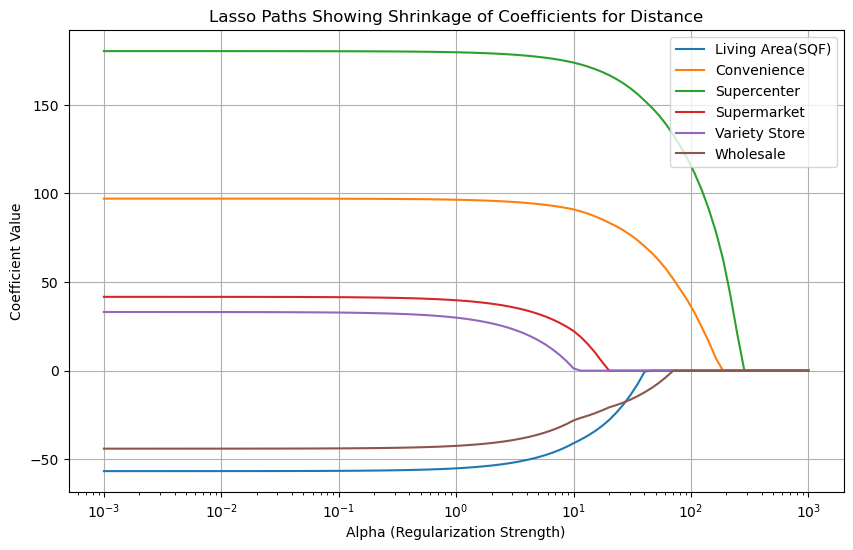

In [264]:
# Define the range of alpha values (regularization strength)
alphas = np.logspace(-3, 3, 100)  # Try values from 0.001 to 100 on a log scale

# Scale the features if needed
scaler = StandardScaler()
X_scaled = transformed_df

# Initialize an empty array to store coefficients
coefs = []

# For each alpha, fit Lasso and store the coefficients
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)

# Convert coefficients list to a numpy array for plotting
coefs = np.array(coefs)

# Plot the regularization path
plt.figure(figsize=(10, 6))

# Plot each feature’s coefficient path
for i, feature in enumerate(['Living Area(SQF)', 'Convenience', 'Supercenter', 'Supermarket', 'Variety Store', 'Wholesale']):
    plt.plot(alphas, coefs[:, i], label=feature)

# Set up plot details
plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Coefficient Value")
plt.title("Lasso Paths Showing Shrinkage of Coefficients for Distance")
plt.legend()
plt.xscale("log")  # Use a log scale for alpha
plt.grid(True)
plt.show()